In [1]:
from dataclasses import dataclass
import pandas as pd
import os
import SimpleITK as sitk

import keras as tfk
from keras import layers as tfkl

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.data import Dataset as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

sns.set_theme()

In [2]:
SEED = 42
BATCH_SIZE = 64
IMG_HEIGHT = 512
IMG_WIDTH = 512
SHUFFLE_BUFFER_SIZE = 100
METRICS = ["accuracy", "recall", "f1_score"]

data_dir = '/kaggle/input/lung-ds-norm/Full_slice'

tfk.utils.set_random_seed(SEED)

In [3]:
import os
import shutil

# Define writable working directory
working_dir = "/kaggle/working/Full_slice_copy"

# Copy the dataset to the working directory (if not already copied)
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
    print("Dataset copied to writable directory.")

# Loop over both "train" and "val" folders
for folder in ["train", "val"]:
    folder_path = os.path.join(working_dir, folder)

    # Move files from 1 and 2 → 0
    for subfolder in ["1", "2"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            for file in os.listdir(subfolder_path):
                shutil.move(os.path.join(subfolder_path, file), os.path.join(folder_path, "0"))

    # Move files from 3 and 4 → 1
    for subfolder in ["3", "4"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            for file in os.listdir(subfolder_path):
                shutil.move(os.path.join(subfolder_path, file), os.path.join(folder_path, "1"))

    # Delete folders 2, 3, and 4
    for subfolder in ["2", "3", "4"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            shutil.rmtree(subfolder_path)

print("Files moved and folders deleted successfully!")

Dataset copied to writable directory.
Files moved and folders deleted successfully!


In [4]:
import os

base_path = "/kaggle/working/Full_slice_copy"

# Loop over "train" and "val"
for folder in ["train", "val"]:
    folder_path = os.path.join(base_path, folder)
    print(f"\nFolder: {folder}")

    # Count files in each remaining subfolder (0 and 1)
    for subfolder in ["0", "1"]:
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.exists(subfolder_path):
            num_files = len(os.listdir(subfolder_path))
            print(f"  {subfolder}: {num_files} images")
        else:
            print(f"  {subfolder}: Does not exist")



Folder: train
  0: 2661 images
  1: 1774 images

Folder: val
  0: 615 images
  1: 410 images


In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=30,            
    # width_shift_range=0.2,        
    # height_shift_range=0.2,       
    shear_range=0.2,              
    zoom_range=0.2,               
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0    
)

val_datagen = ImageDataGenerator(

)

train_generator = train_datagen.flow_from_directory(
    working_dir + "/train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    #subset='training'               
)

val_generator = val_datagen.flow_from_directory(
    working_dir + "/val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
    #subset='val'
)

Found 4435 images belonging to 2 classes.
Found 1025 images belonging to 2 classes.


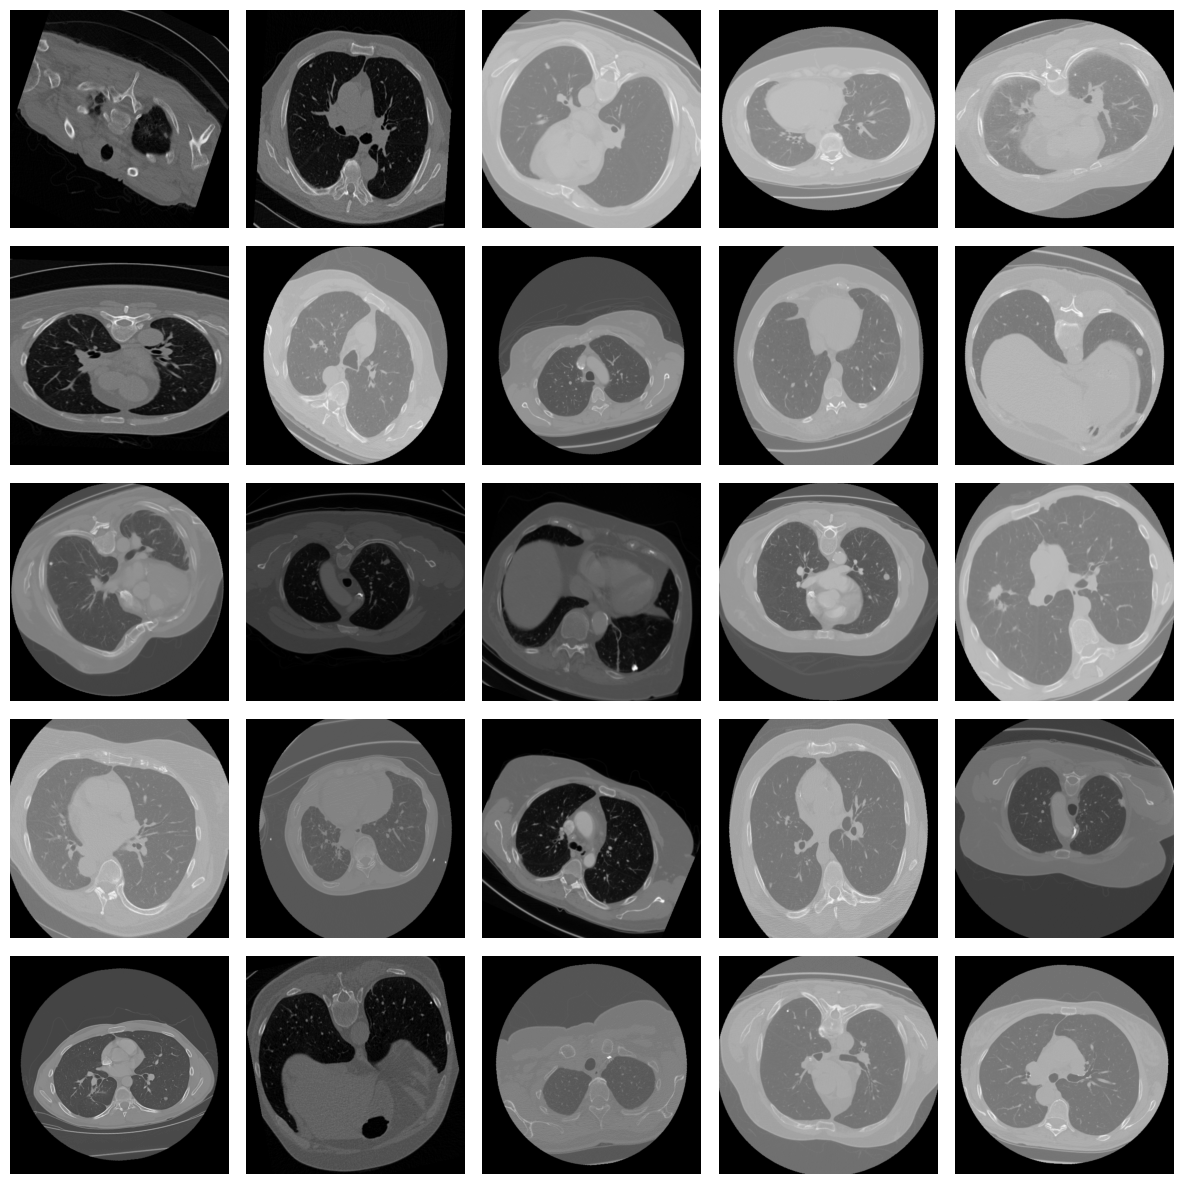

In [6]:
# Get one batch of augmented images
augmented_images, _ = next(train_generator)  # Ignore labels (_)

# Plot a 5x5 grid of augmented images
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
axes = axes.flatten()

for img, ax in zip(augmented_images[:25], axes):  # Take the first 25 images
    ax.imshow(img[:, :, 0], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
@dataclass
class Hyperparameters:
    # Model
    activation = "relu"
    # Training
    # noise_std: float = 0.05 # then try 0.1
    optimiser = tfk.optimizers.Adam
    learning_rate = 1e-4
    weight_decay = 1e-4
    regularization1 = tfk.regularizers.L1L2(l1=1e-5, l2=0)
    regularization2 = tfk.regularizers.L1L2(l1=0, l2=0)
    loss = tfk.losses.BinaryCrossentropy(from_logits=False)
    epochs = 50
    ## Early stopping parameters
    es_patience = 10
    es_min_delta = 1e-2
    ## Learning rate schedule
    lr_patience = 5
    lr_decay_factor = 0.3
    lr_min_delta = 5e-2 
    min_lr = 1e-6

hp = Hyperparameters()

In [8]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
classes = np.array([0, 1])

# Compute class weights automatically
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_generator.classes)

# Convert to dictionary
class_weights = dict(zip(classes, class_weights))

print(class_weights)

{0: 0.8333333333333334, 1: 1.25}


In [9]:
def build_model(hp: Hyperparameters,
                feature_extractor: tfk.applications):
    
    inputs = tfkl.Input((IMG_HEIGHT, IMG_WIDTH, 3))

    # x = tfkl.Rescaling(1./255)(inputs)
    # gn = tfkl.GaussianNoise(hp.noise_std)(x)
    # x = tfkl.Rescaling(255)(gn)

    backbone_output = feature_extractor(inputs)

    conv_layer = tfkl.Conv2D(1024, kernel_size=(3, 3), activation='relu', padding='same')(backbone_output) 
    max_pool_layer = tfkl.MaxPooling2D(pool_size=(2, 2))(conv_layer)
    flatten_layer = tfkl.Flatten()(max_pool_layer) 

    x = tfkl.Dropout(0.6)(flatten_layer)

    x = tfkl.Dense(1024, activation='relu')(x)
    x = tfkl.Dense(512, activation='relu')(x)
    x = tfkl.Dense(256, activation='relu')(x)
    #x = tfkl.Dense(128, activation='relu')(x)

    x = tfkl.Dropout(0.4)(x)

    output = tfkl.Dense(1, activation="sigmoid")(x)
    
    model = tfk.Model(inputs, output)
    return model

In [16]:
def fit(model: tfk.Model,
        train_generator: ImageDataGenerator,
        val_generator: ImageDataGenerator,
        hp: Hyperparameters):
    model.compile(loss=hp.loss,
                  optimizer=hp.optimiser(learning_rate=hp.learning_rate, weight_decay=hp.weight_decay), 
                  metrics=['accuracy'])
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=hp.epochs,
        class_weight=class_weights,
        #validation_data=val_dataset,
        callbacks=[
            tfk.callbacks.EarlyStopping(monitor='val_loss', 
                                        #mode='min',
                                        patience=hp.es_patience, 
                                        restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(
                factor=hp.lr_decay_factor,
                patience=hp.lr_patience,
                min_delta=hp.lr_min_delta,
                min_lr=hp.min_lr,
                verbose=1,
            )
    ]
    
    ).history

    return model, history

In [17]:
backbone = tfk.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(512,512,3),
    pooling=None #'avg'
)

backbone.trainable = False

model = build_model(hp, backbone)

model, history = fit(model, train_generator, val_generator, hp)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 290s 4s/step - accuracy: 0.5359 - loss: 1.0562 - val_accuracy: 0.6020 - val_loss: 0.6827 - learning_rate: 1.0000e-04
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.6147 - loss: 0.6548 - val_accuracy: 0.5473 - val_loss: 0.7024 - learning_rate: 1.0000e-04
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.6367 - loss: 0.6325 - val_accuracy: 0.6146 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.6840 - loss: 0.6165 - val_accuracy: 0.5668 - val_loss: 0.7375 - learning_rate: 1.0000e-04
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.6668 - loss: 0.6075 - val_accuracy: 0.6166 - val_loss: 0.6895 - learning_rate: 1.0000e-04
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7119 - loss: 0.5687
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
70/70 ━━━━━━━━━━━━━━━━━━━━ 245s 3s/step - accuracy: 0.7118 - loss

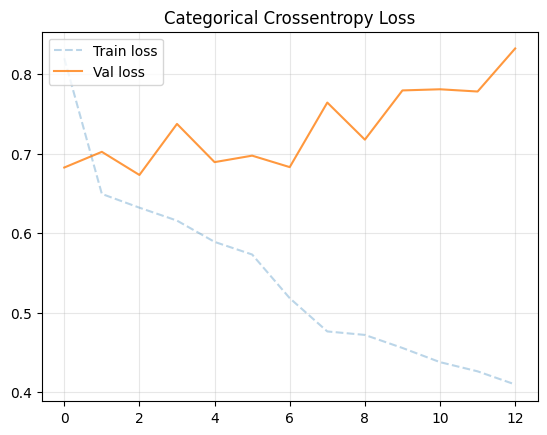

In [18]:
# Plot loss curves
plt.style.use('default')
plt.plot(history['loss'], label='Train loss', alpha=0.3, linestyle='--')
plt.plot(history['val_loss'], label='Val loss', alpha=0.8)
plt.title('Categorical Crossentropy Loss')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

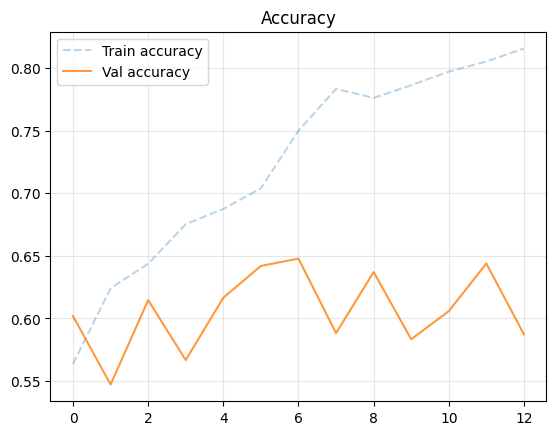

In [19]:
# Plot accuracy curves
plt.style.use('default')
plt.plot(history['accuracy'], label='Train accuracy', alpha=0.3, linestyle='--')
plt.plot(history['val_accuracy'], label='Val accuracy', alpha=0.8)
plt.title('Accuracy')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 960ms/step
Accuracy:  0.6146341463414634


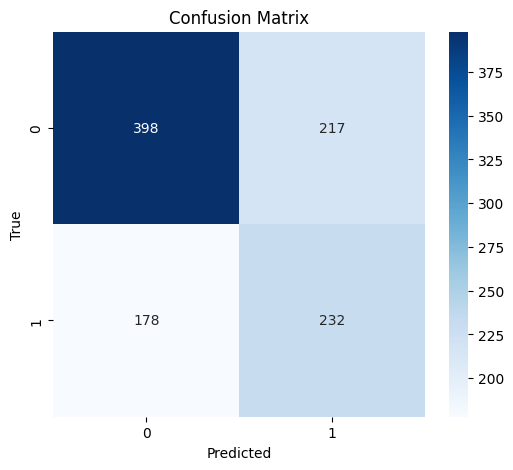

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Collect true labels
y_true = []
for _, labels in val_generator:
    y_true.extend(labels)
    if len(y_true) >= val_generator.samples:  # Stop when all samples are processed
        break

y_true = np.array(y_true)

# If class_mode is 'binary', labels might have an extra dimension (shape: (batch_size, 1)), so we flatten
if val_generator.class_mode == 'binary':
    y_true = y_true.flatten()

# Predict on validation data
y_pred = model.predict(val_generator)

# Convert probabilities to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# Print accuracy
print("Accuracy: ", accuracy_score(y_true, y_pred_classes))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
